In [7]:
# Install necessary packages
!pip install numpy matplotlib scipy networkx qiskit mqt-bench scikit-learn
# Install the latest version of the mqt-predictor
!pip install git+https://github.com/cda-tum/mqt-predictor.git@main

zsh:1: command not found: pip
zsh:1: command not found: pip


In [8]:
# Standard library imports
import os
import glob
import ast 

# Numerical and scientific computing
import numpy as np
import scipy as sp
from scipy.stats import pearsonr, ConstantInputWarning
import random
# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Qiskit and quantum computing
import qiskit.qasm2


# MQT predictor and benchmarking tools
import mqt.bench
from mqt.predictor.reward import expected_fidelity, estimated_success_probability

# Helper functions
from mqt.predictor.ml.helper import hellinger_distance
from mqt.predictor.ml.helper import calc_device_specific_features

# Machine learning with scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.inspection import permutation_importance

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.ensemble._forest")
warnings.filterwarnings("ignore", category=ConstantInputWarning)

import zipfile

In [9]:
# Get the path to the current data.zip file
data_dir = os.path.join(os.getcwd(), 'data')

# Ensure the zip file exists
zip_file_path = data_dir + '.zip'
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"Zip file not found at {zip_file_path}")

# Unzip the data files into the current directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)  # Extracts into the current directory

print(f"Files extracted from {zip_file_path} into the current directory.")

Files extracted from /Users/patrickhopf/Code/mqt/mqt-predictor/evaluations/figure_of_merit_analysis/data.zip into the current directory.


# IMPORT AND PREPARE DATA

In [10]:
# Dictionaries to store the calculated figures of merit and Hellinger distance
depth, esp, fidelity, num_gates, hellinger = {}, {}, {}, {}, {}

qpus = ['apollo', 'qexa'] 
for qpu in qpus:
    depth[qpu], esp[qpu], fidelity[qpu], num_gates[qpu], hellinger[qpu] = {}, {}, {}, {}, {}

    try: # Import QPU
        device = mqt.bench.devices.get_device_by_name('iqm_' + qpu)
    except Exception as e:
        # Device 'iqm_qexa' calibration data not yet "publicly" available
        print(f"Device 'iqm_{qpu}' not found among available providers.")
        print(f"Using precomputed ESP and fidelity values with historical calibration data.")
        device = None
    
    # Get a list of all execution files
    execution_files = sorted(glob.glob(os.path.join(data_dir, 'execution', qpu, '*.txt')))
    print(f"Found {len(execution_files)} execution files for {qpu}")

    # Iterate over the execution files
    for execution_file in execution_files:
        # file_name is sth. like 'wstate_indep_qiskit_20'
        file_name = os.path.basename(execution_file).replace(".txt", "")

        try:
            # Load the corresponding circuit
            circuit = qiskit.qasm2.load(os.path.join(data_dir, 'qasm', file_name + '.qasm'))

            # Load the noiseless simulation file
            noiseless_file = os.path.join(data_dir, 'simulation', qpu, file_name + '.txt')

            # Open the files and read the counts
            with open(noiseless_file, 'r') as f:
                noiseless_counts = ast.literal_eval(f.read())
            with open(execution_file, 'r') as f:
                execution_counts = ast.literal_eval(f.read())

            num_execution_shots = sum(execution_counts.values())
            num_noiseless_shots = sum(noiseless_counts.values())

            # Transform counts to probabilities
            noiseless_probs_org = {k: v / num_noiseless_shots for k, v in noiseless_counts.items()}

            # Only keep the states that are distinguishable with the number of execution shots
            noiseless_probs = {k: v for k, v in noiseless_probs_org.items() if v * num_execution_shots >= 1}

            # Get the states and their noiseless probabilities
            states = sorted(set(noiseless_counts.keys()).union(execution_counts.keys()))
            noiseless_probs_all = np.array([noiseless_probs.get(state, 0) for state in states])

            # Get the execution probabilities
            execution_counts_all = np.array([execution_counts.get(state, 0) for state in states])
            execution_probs_all = execution_counts_all / num_execution_shots
            
            # If they do not resemble a probability distribution, skip the file (e.g., due to too few shots)
            if not np.isclose(sum(noiseless_probs_all), 1, 0.05) or not np.isclose(sum(execution_probs_all), 1, 0.05):
                # print(f"Skipping {file_name} because probabilities do not sum to 1")
                continue
            
            # File paths for the figures of merit
            path = os.path.join(data_dir, 'foms', qpu, file_name)

            num_gates_file = f'{path}_num_gates.txt'
            depth_file = f'{path}_depth.txt'
            fidelity_file = f'{path}_fidelity.txt'
            esp_file = f'{path}_esp.txt'
            #esp_file = os.path.join(directory, 'foms', 'apollo', file_name +'_esp.txt')

            # Hellinger distance will be saved as labels
            labels_file = os.path.join(data_dir, 'labels', qpu, file_name)
            hellinger_file = f'{labels_file}_hellinger.txt'

            # Calculate all values and save them to a file or load them from the file if it exists

            # Depth
            if not os.path.exists(depth_file):
                d = circuit.depth()
                with open(depth_file, 'w') as f:
                    f.write(str(d))
            else:
                with open(depth_file, 'r') as f:
                    d = int(f.read())
            if d > 1000:
                # print(f"Skipping {file_name} because depth is too high")
                continue
            depth[qpu][file_name] = d

            # Fidelity
            if device and not os.path.exists(fidelity_file):
                fidelity[qpu][file_name] = expected_fidelity(circuit, device)
                with open(fidelity_file, 'w') as f:
                    f.write(str(fidelity[qpu][file_name]))
            else:
                with open(fidelity_file, 'r') as f:
                    fidelity[qpu][file_name] = float(f.read())

            # ESP
            if device and not os.path.exists(esp_file):
                esp[qpu][file_name] = estimated_success_probability(circuit, device)
                with open(esp_file, 'w') as f:
                    f.write(str(esp[qpu][file_name]))
            else:
                with open(esp_file, 'r') as f:
                    esp[qpu][file_name] = float(f.read())
            
            # Number of gates
            if not os.path.exists(num_gates_file):
                num_gates[qpu][file_name] = sum(circuit.count_ops().values())
                with open(num_gates_file, 'w') as f:
                    f.write(str(num_gates[qpu][file_name]))
            else:
                with open(num_gates_file, 'r') as f:
                    num_gates[qpu][file_name] = int(f.read())

            # Execution vs noiseless Hellinger distance
            if not os.path.exists(hellinger_file):
                hellinger[qpu][file_name] = hellinger_distance(noiseless_probs_all, execution_probs_all)
                with open(hellinger_file, 'w') as f:
                    f.write(str(hellinger[qpu][file_name]))
            else:
                with open(hellinger_file, 'r') as f:
                    hellinger[qpu][file_name] = float(f.read())

        except Exception as e:
            print(f"Error processing {qpu}: {e}")
            continue

    print(f"Stored {len(depth[qpu])} files for {qpu}, after removing too high depths and non-probability distributions. \n")

Found 354 execution files for apollo
Stored 222 files for apollo, after removing too high depths and non-probability distributions. 

Found 354 execution files for qexa
Stored 223 files for qexa, after removing too high depths and non-probability distributions. 



# EVALUATION OF CURRENT FIGURES OF MERIT

In [11]:
cols = ['#FE6100', '#648FFF']
names = ['Q20-A', 'Q20-B']

apollo Gate Count correlation 0.461
apollo Circuit Depth correlation 0.456
apollo Estimated Success Probability correlation -0.586
apollo Expected Fidelity correlation -0.66
qexa Gate Count correlation 0.605
qexa Circuit Depth correlation 0.62
qexa Estimated Success Probability correlation -0.703
qexa Expected Fidelity correlation -0.799


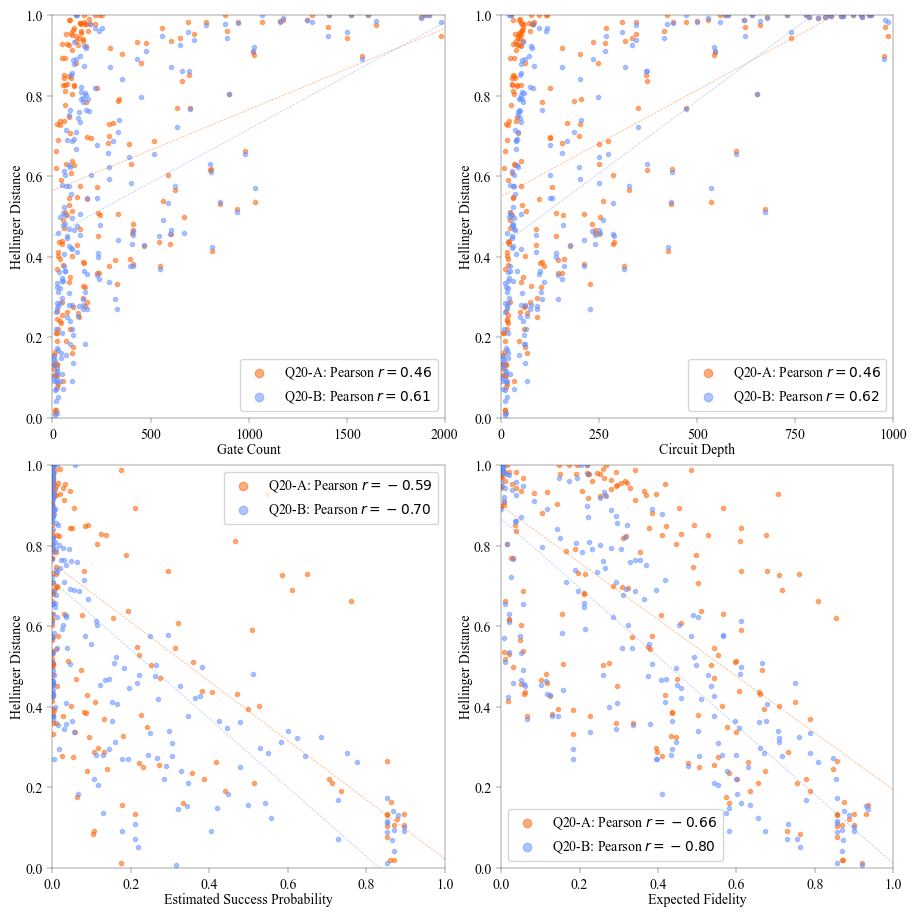

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
data = {}

for i, qpu in enumerate(qpus):

    # Collect data for plot
    depth_list = list(depth[qpu].values())
    esp_list = list(esp[qpu].values())
    fidelity_list = list(fidelity[qpu].values())
    num_gates_list = list(num_gates[qpu].values())
    execution_noiseless_dist_list = list(hellinger[qpu].values())

    data[qpu] = [   
        (num_gates_list, execution_noiseless_dist_list, 'Gate Count', 'Hellinger Distance'),
        (depth_list, execution_noiseless_dist_list, 'Circuit Depth', 'Hellinger Distance'),
        (esp_list, execution_noiseless_dist_list, 'Estimated Success Probability', 'Hellinger Distance'),
        (fidelity_list, execution_noiseless_dist_list, 'Expected Fidelity', 'Hellinger Distance'),
    ]

    for ax, (x, y, xlabel, ylabel) in zip(axs.flatten(), data[qpu]):
        # Normalize for Pearson correlation
        x_max, y_max = np.max(x), np.max(y)
        x_norm, y_norm = np.array(x) / x_max, np.array(y) / y_max

        # Calculate Pearson correlation
        slope, intercept, rval, pval, std_err = sp.stats.linregress(x_norm, y_norm)
        x_plot = np.linspace(np.min(x) - 1, np.max(x) + 1, 100)
        y_plot = (slope * (x_plot / x_max) + intercept) * y_max
        ax.plot(x_plot, y_plot, color=cols[i], linewidth=0.5, alpha=0.5, linestyle='--')

        # Should be the same as the calculated Pearson correlation
        r, p = pearsonr(x_norm, y_norm)
        assert np.isclose(r, rval), f"r: {r}, rval: {rval}"
        assert np.isclose(p, pval), f"p: {p}, pval: {pval}"

        # Plot the data
        pearson_label = names[i] + ': Pearson $r = {:.2f}$'.format(r)
        ax.scatter(x, y, color=cols[i], marker='.', label=pearson_label, alpha=0.5)

        # Adjust x-axis
        if xlabel == 'Gate Count':
            ax.set_xlim(0, 2000)
            ax.xaxis.set_major_locator(MultipleLocator(500))
        elif xlabel == 'Circuit Depth':
            ax.set_xlim(0, 1000)
            ax.xaxis.set_major_locator(MultipleLocator(250))
        else:
            ax.set_xlim(0, 1)
        ax.set_xlabel(xlabel, labelpad=1)

        # Adjust y-axis
        ax.set_ylim(0., 1.0)
        ax.set_ylabel(ylabel, labelpad=1)
        ax.yaxis.set_major_locator(MultipleLocator(0.2)) 

        # Adjust tick size and tick spacing
        ax.tick_params(axis='both', which='major', width=0.25)

        # Set border line width
        for spine in ax.spines.values():
            spine.set_linewidth(0.25)

        ax.legend(scatterpoints=1)  # Adjust legend text size
        legend = ax.legend(markerscale=2.)
        
        print(qpu, xlabel, "correlation", np.round(r, 3))

fig.tight_layout(pad=0.1, h_pad=0.2, w_pad=0)
plt.savefig(os.path.join(data_dir, 'figures', 'correlation.pdf'), bbox_inches='tight')

# PROPOSED APPROACH

In [13]:
X = {qpu: [] for qpu in qpus}
Y = {qpu: [] for qpu in qpus}

# Both QPUs have the same architecture (only different calibration data)
device = mqt.bench.devices.get_device_by_name('iqm_apollo')

for qpu in qpus:
    # save the training data to
    path = os.path.join(data_dir, 'features', qpu) 

    native_gates = ["r", "cz"] # iqm gates

    # Get a list of all execution files
    qasm_files = sorted(glob.glob(os.path.join(data_dir, 'execution', qpu , '*.txt')))

    # Iterate over the execution files
    for qasm_file in qasm_files:
        # file_name is sth. like 'qft_10'
        file_name = os.path.basename(qasm_file).replace(".txt", "")

        try:
            circ = qiskit.qasm2.load(os.path.join(data_dir, 'qasm', file_name + '.qasm'))
            try:
                y = hellinger[qpu][file_name]
                Y[qpu].append(y)
            except KeyError:
                continue # No Hellinger distance available, e.g. if depth was too high

            if not os.path.exists(path + f'/{file_name}.txt'):
                x_dict = calc_device_specific_features(circ, device)
                x = list(x_dict.values())
                X[qpu].append(x)

                np.savetxt(path + f'/{file_name}.txt', np.array(x))
                #print(f"Saved features for {file_name}")
            else:
                X[qpu].append(np.loadtxt(path + f'/{file_name}.txt'))
                #print(f"Loaded features for {file_name}")

        except Exception as e:
            print(f"Error processing circuit {qasm_file}: {e}")
            continue

    print(f"Extracted features and labels for {len(X[qpu])} files for {qpu}")

Extracted features and labels for 222 files for apollo
Extracted features and labels for 223 files for qexa


In [14]:
idx_dict = {qpu: {} for qpu in qpus}

# Indicate which features to use for the prediction
for qpu in qpus:

    gate_dict = {
        "R Gate Count":  True, 
        "CZ Gate Count": True
    }
    num_qubits = 20
    qubit_dict = {f'Qubit{i}': True for i in range(num_qubits)}

    supermarq_plus_dict = {
        'Circuit Depth':         True,
        'Number of Qubits':      False,
        'Critical Depth':        True, 
        'Entanglement Ratio':    True,
        'Parallelism':           True, 
        'Liveness':              True,
        
        'Directed Program Comm.':   True, 
        'Single-Qubit Gate Ratio':  True, 
        'Multi-Qubit Gate Ratio':   True,
    }
    
    idx_dict[qpu] = {**gate_dict, **qubit_dict, **supermarq_plus_dict}

In [15]:
X_train, X_test, y_train, y_test = {}, {}, {}, {}

for qpu in qpus:
    X_arr = np.array(X[qpu])
    Y_arr = np.array(Y[qpu])

    # Mask the features
    mask = np.array([val for val in idx_dict[qpu].values()])
    X_masked = X_arr[:, mask]

    # Split the data into training and test sets
    X_train[qpu], X_test[qpu], y_train[qpu], y_test[qpu] = train_test_split(
        X_masked, Y_arr, test_size=0.2, random_state=123
    )
    print(f"Training data shape for {qpu}: features {X_train[qpu].shape}, labels {y_train[qpu].shape}")
    print(f"Test data shape for {qpu}: featuers {X_test[qpu].shape}, labels {y_test[qpu].shape} \n")

Training data shape for apollo: features (177, 30), labels (177,)
Test data shape for apollo: featuers (45, 30), labels (45,) 

Training data shape for qexa: features (178, 30), labels (178,)
Test data shape for qexa: featuers (45, 30), labels (45,) 



## Hyperparameter search / model training

In [16]:
# Helper functions

# Save best parameter index to file
def save_best_params(idx, best_params, path):
    file = {idx: best_params}
    with open(path, 'w') as f:
        f.write(str(file))

# Load best parameter index from file
def load_best_params(path):
    with open(path, 'r') as f:
        file = eval(f.read())
    idx, best_params = list(file.keys())[0], list(file.values())[0]
    return idx, best_params

seed = 2
np.random.seed(seed)
random.seed(seed)

NameError: name 'random' is not defined

In [15]:
models = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=seed, verbose=0, n_jobs=5),
        'params': {
            'n_estimators': [30, 40, 50, 60],  # Number of trees in the forest; more trees reduce variance.
            'criterion': ['absolute_error', 'squared_error'],  # Metric to evaluate splits; affects tree quality.
            'max_depth': [10, 20, 30, None],  # Max depth of trees; smaller values prevent overly complex trees (reduce overfitting).
            'min_samples_split': [4, 5, 0.1],  # Min samples to split an internal node; higher values reduce sensitivity to noise.
            'min_samples_leaf': [2, 3, 4, 5, 0.1],  # Min samples in a leaf node; larger values create simpler, generalized trees.
            # This is the main RANDOM FOREST parameter
            'max_features': ['sqrt', 'log2', None],  # Max features to consider at each split; lower values reduce overfitting by randomness.
            'max_leaf_nodes': [None, 20, 40, 60, 80, 100],  # Max leaf nodes in the tree; fewer nodes limit model complexity.
            'min_impurity_decrease': [0.01, 0.1, 0.2],  # Min impurity decrease for a split; higher values prevent splits on minor gains.
            'ccp_alpha': [0.01, 0.05],  # Complexity parameter for pruning; larger values simplify the tree (reduce overfitting).
            'max_samples': [0.5, 1.0],  # Max samples to draw for training each tree; smaller values increase diversity, reducing overfitting.
            'monotonic_cst': [[ # Monotonic constraints; improves interpretability, not directly related to overfitting. 
                                # -1 means decreasing, 0 means no constraint, and 1 means increasing
                                # Gate counts
                                1, # R gate count
                                1, # CZ gate count
                                # Qubit counts
                                0, # Qubit 0
                                0, # Qubit 1
                                0, # Qubit 2
                                0, # Qubit 3
                                0, # Qubit 4
                                0, # Qubit 5
                                0, # Qubit 6
                                0, # Qubit 7
                                0, # Qubit 8
                                0, # Qubit 9
                                0, # Qubit 10
                                0, # Qubit 11
                                0, # Qubit 12
                                0, # Qubit 13
                                0, # Qubit 14
                                0, # Qubit 15
                                0, # Qubit 16
                                0, # Qubit 17
                                0, # Qubit 18
                                0, # Qubit 19
                                # Supermarq+
                                1, # Circuit depth
                                0, # Critical depth
                                1, # Entanglement ratio
                                0, # Parallelism
                                0, # Liveness
                                0, # Directed program communication
                                0, # Single qubit gates ratio
                                0, # Multi qubit gates ratio
                               ], None
                             ],  
        }
    }
}

NOTE: Grid search / training takes time!
If training is disabeled, the best parameters will be loaded from previous search.

In [16]:
enable_training = False

if enable_training:
    # Initialize dictionary to store the best model for each QPU
    best_model = {qpu: None for qpu in qpus}

    # Path to save the best parameters
    trainnig_path = os.path.join(data_dir, 'training')

    for qpu in qpus:
        best_score = -np.inf
        
        # Load the best parameters if they exist
        filename = f'{trainnig_path}/{qpu}_best_params.txt'
        if os.path.exists(filename):
            idx, best_params = load_best_params(filename)
            print(f'Loaded best parameters for {qpu}: {best_params}')
            continue
        else:
            idx = 0
            best_params = {}
            print(f'No best parameters found')


        for model_name, model_info in models.items():
            param_grid = ParameterGrid(model_info['params'])
            gird = list(param_grid)
            len_grid = len(gird)

            for i, params in enumerate(gird[idx:]):
                i += idx
                print(f'Progress: {i}/{len_grid}')
                model = model_info['model'].set_params(**params)
                
                # Initialize cross-validation
                kf = KFold(n_splits=3, shuffle=True, random_state=42)
                cv_scores = []

                # Perform cross-validation
                for train_index, val_index in kf.split(X_train[qpu]):
                    X_train_split, X_val_split = X_train[qpu][train_index], X_train[qpu][val_index]
                    y_train_split, y_val_split = y_train[qpu][train_index], y_train[qpu][val_index]

                    # Train and validate
                    model.fit(X_train_split, y_train_split)
                    predictions = model.predict(X_val_split)
                    score = pearsonr(predictions, y_val_split)[0]  # Pearson correlation coefficient
                    cv_scores.append(score)

                # Compute average score across all folds
                mean_score = np.mean(cv_scores)

                # Update the best model with a deep copy
                if mean_score >= best_score:
                    best_model[qpu] = copy.deepcopy(model)  # Ensure an independent copy is stored
                    best_score = mean_score

                    print(f'Parameters: {params}')
                    print(f'Cross-Validation Mean Score: {mean_score}')
                    print(f'Associated Test Score: {pearsonr(best_model[qpu].predict(X_test[qpu]), y_test[qpu])[0]}')

                    # Save the best parameters to a file
                    save_best_params(i, params, filename)

        print(f'Best overall model on {qpu}: {best_model[qpu]}')

In [17]:
# Load the best parameters
trainnig_path = os.path.join(data_dir, 'training')
best_model = {qpu: None for qpu in qpus}

for qpu in qpus:
    # Load the best parameters if they exist
    filename = f'{trainnig_path}/{qpu}_best_params.txt'
    if os.path.exists(filename):
        idx, best_params = load_best_params(filename)
        best_model[qpu] = RandomForestRegressor(random_state=seed, verbose=0, n_jobs=5).set_params(**best_params)
        print(f'Loaded best parameters for {qpu}: {best_params}')
    else:
        print(f'No best parameters found')

Loaded best parameters for apollo: {'ccp_alpha': 0.01, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': 100, 'max_samples': 1.0, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 3, 'min_samples_split': 0.1, 'monotonic_cst': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], 'n_estimators': 60}
Loaded best parameters for qexa: {'ccp_alpha': 0.01, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.5, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 3, 'min_samples_split': 5, 'monotonic_cst': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], 'n_estimators': 40}


In [18]:
trained_models, y_pred = {}, {}
for qpu in qpus:
    trained_models[qpu] = best_model[qpu].fit(X_train[qpu], y_train[qpu])
    y_pred[qpu] = trained_models[qpu].predict(X_test[qpu])

apollo:  Figure of Merit:
Pearson r: 0.876, pval: 0.000

qexa:  Figure of Merit:
Pearson r: 0.947, pval: 0.000



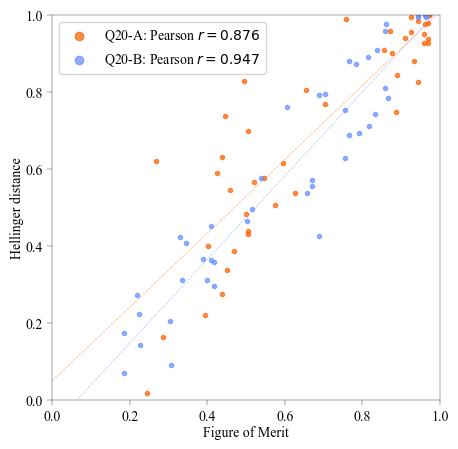

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

data = {}
for i, qpu in enumerate(qpus):

    # Collect data for plot
    model_prediction = list(y_pred[qpu])
    true_labels = list(y_test[qpu])

    ax = axs
    x = model_prediction
    y = true_labels
    xlabel = 'Figure of Merit'
    ylabel = 'Hellinger distance'

    # Normalize for Pearson correlation
    x_max, y_max = np.max(x), np.max(y)
    x_norm, y_norm = np.array(x) / x_max, np.array(y) / y_max

    # Calculate Pearson correlation
    slope, intercept, rval, pval, std_err = sp.stats.linregress(x_norm, y_norm)
    x_plot = np.linspace(np.min(x)-1, np.max(x)+1, 100)
    y_plot = (slope * (x_plot / x_max) + intercept) * y_max
    ax.plot(x_plot, y_plot, color=cols[i], linewidth=0.5, alpha=0.5, linestyle='--')

    # Should be the same as the calculated Pearson correlation
    r, p = pearsonr(x_norm, y_norm)
    assert np.isclose(r, rval), f"r: {r}, rval: {rval}"
    assert np.isclose(p, pval), f"p: {p}, pval: {pval}"

    print(f'{qpu}:  {xlabel}:')
    print(f'Pearson r: {rval:.3f}, pval: {pval:.3f}\n')

    pearson_label = names[i] + ': Pearson $r = {:.3f}$'.format(r)

    # Plot the data
    ax.scatter(x, y, color=cols[i], marker='.', label=pearson_label, alpha=0.7)

    # Adjust x-axis
    if xlabel == 'Number of gates':
        ax.set_xlim(0, 2000)
        ax.xaxis.set_major_locator(MultipleLocator(500))
    elif xlabel == 'Circuit depth':
        ax.set_xlim(0, 1000)
        ax.xaxis.set_major_locator(MultipleLocator(250))
    else:
        ax.set_xlim(0, 1)
    ax.set_xlabel(xlabel, labelpad=1)

    # Adjust y-axis
    ax.set_ylim(0., 1.0)
    ax.set_ylabel(ylabel, labelpad=1)
    ax.yaxis.set_major_locator(MultipleLocator(0.2)) 

    # Adjust tick size and tick spacing
    ax.tick_params(axis='both', which='major', width=0.25)

    # Set border line width
    for spine in ax.spines.values():
        spine.set_linewidth(0.25)

    ax.legend(scatterpoints=1)  # Adjust legend text size

    legend = ax.legend(markerscale=2.)

plt.savefig(os.path.join(data_dir, 'figures', 'prediction.pdf'), bbox_inches='tight')

## Feature Importance

In [20]:
def group_qubit_features(imps, names) -> tuple[np.ndarray, list]:
    """Groups qubit features and returns the grouped importances."""
    qubit_indices = [i for i, name in enumerate(names) if name.startswith('Qubit')]
    qubit_importances = imps[qubit_indices]
    qubit_importances_avg = np.average(qubit_importances, axis=0)

    # Remove individual qubit importances
    new_imps = [imps[i] for i in range(len(imps)) if i not in qubit_indices]
    new_names = [name for i, name in enumerate(names) if i not in qubit_indices]

    # Append the grouped qubit importances
    new_imps.append(qubit_importances_avg)
    new_names.append('Average qubit features')

    return np.array(new_imps), new_names

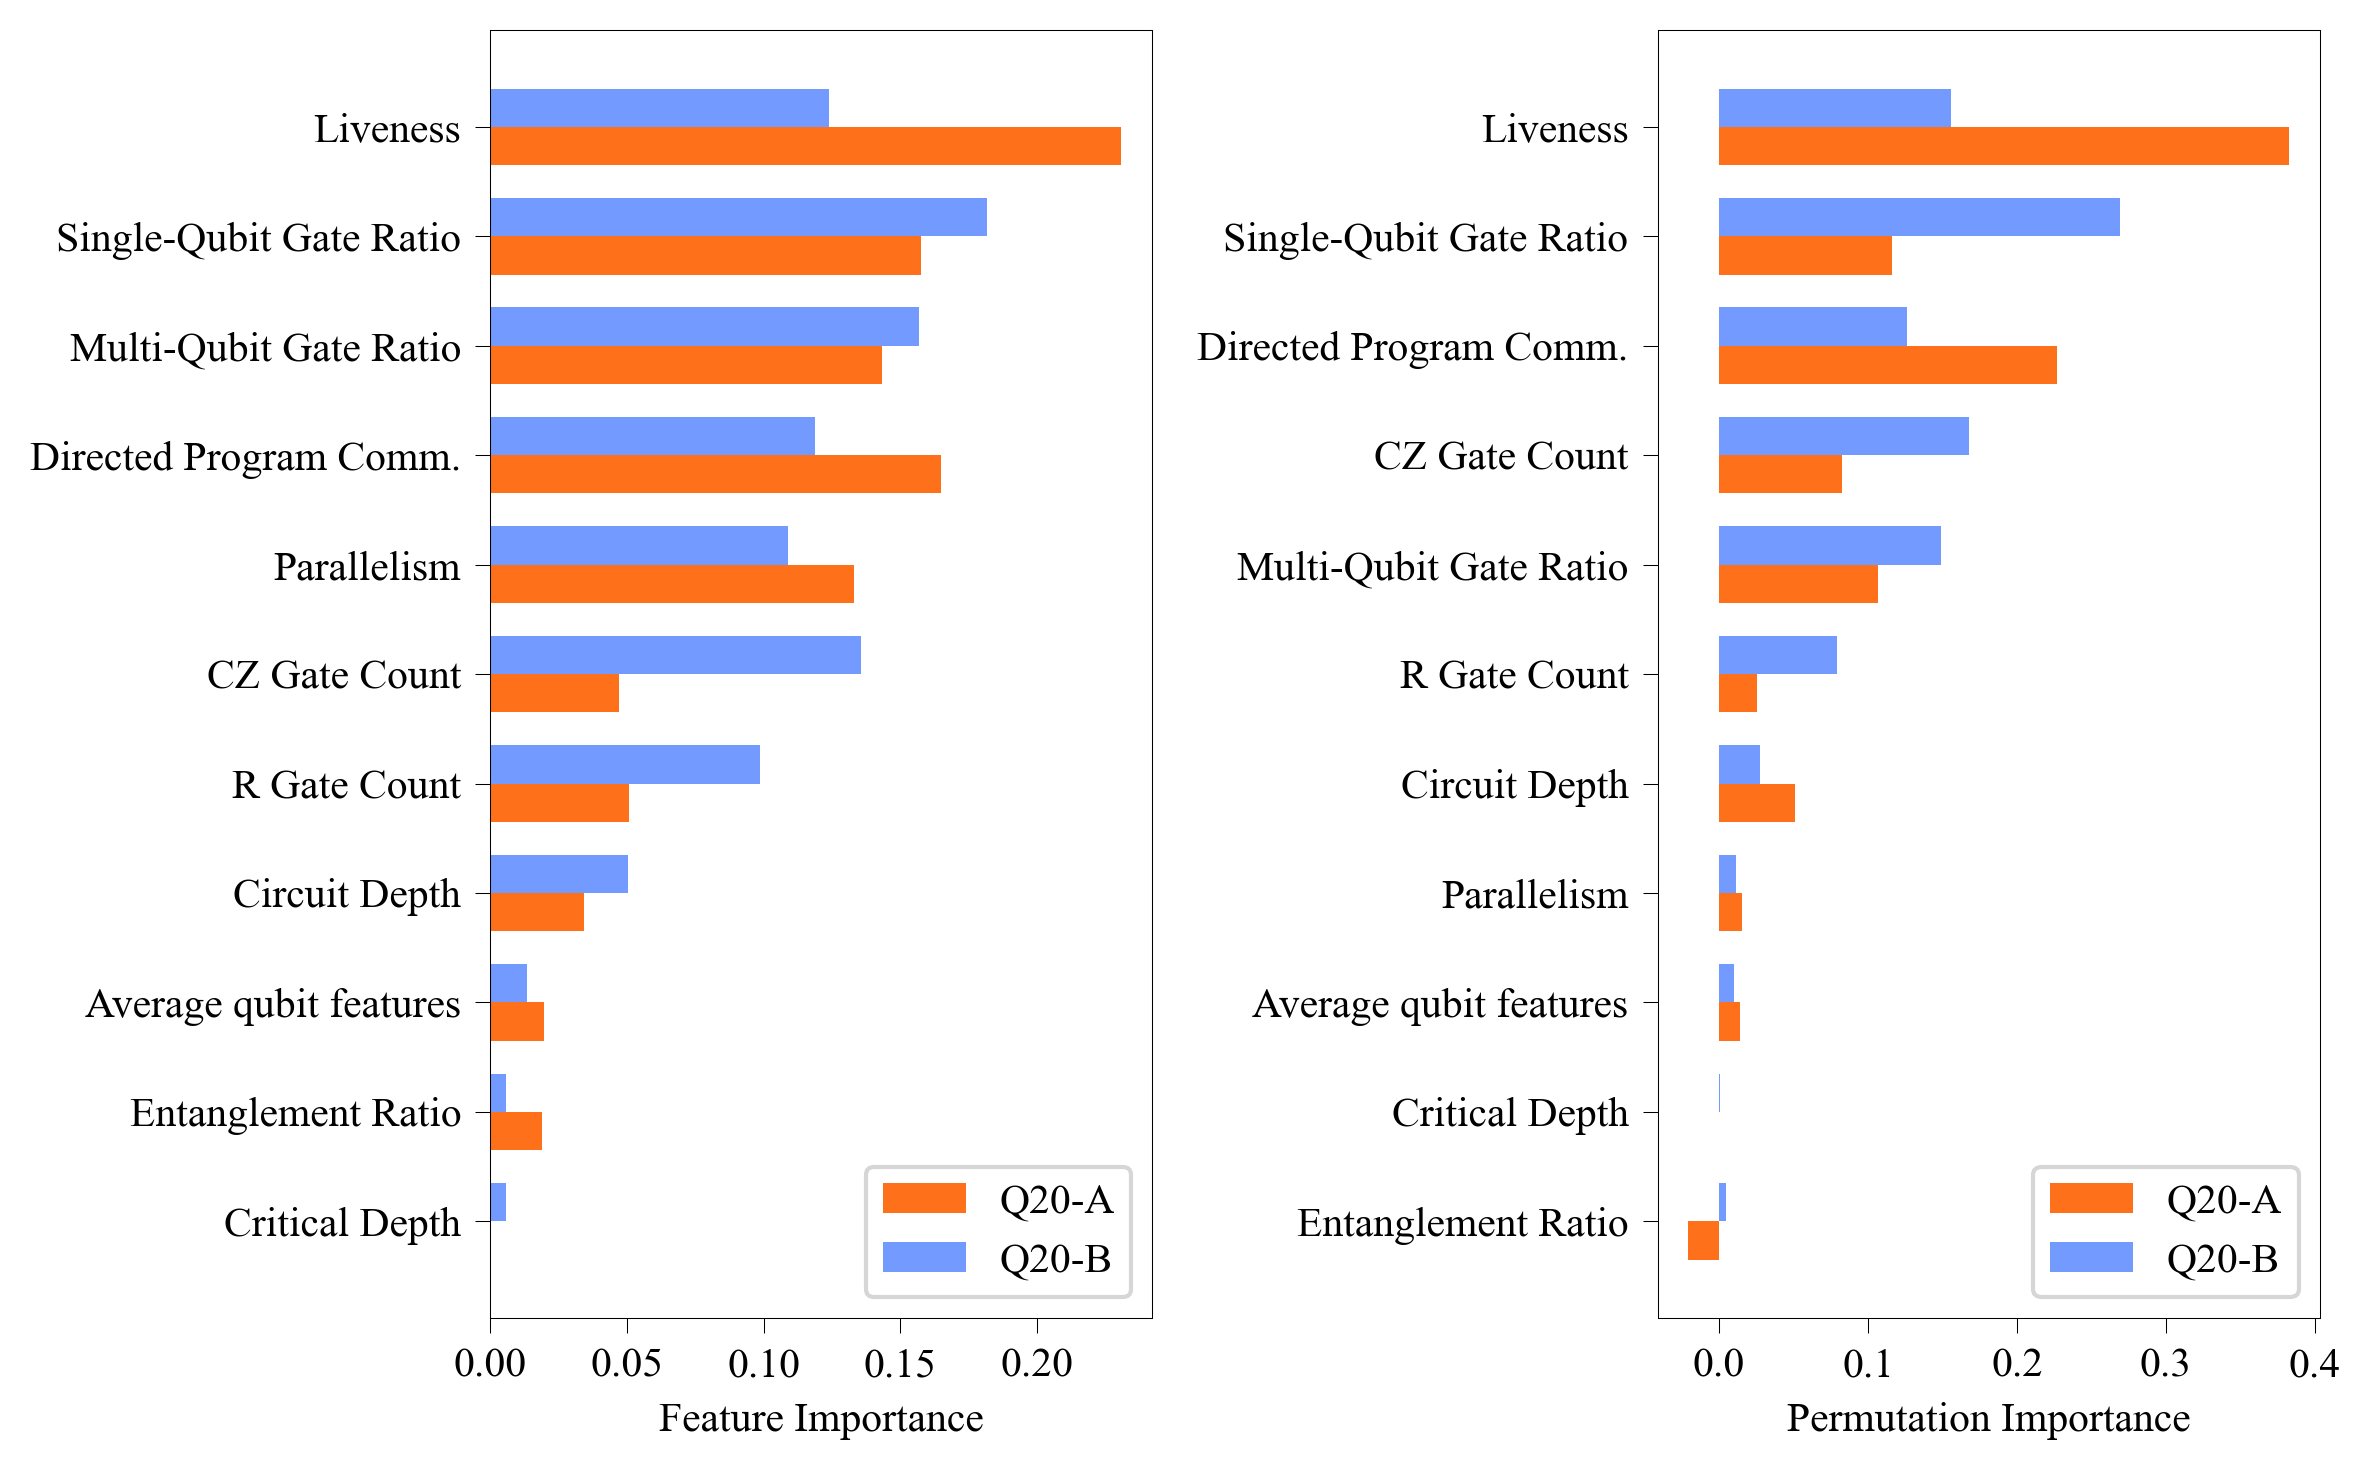

In [ ]:
# Calculate feature importance for each QPU
feature_importances_apollo = best_model['apollo'].feature_importances_
feature_importances_qexa = best_model['qexa'].feature_importances_

# Feature names
feature_names = [name for name in idx_dict['apollo'].keys() if idx_dict['apollo'][name]]

# Calculate permutation importance for each QPU
perm_importances_apollo = permutation_importance(
    best_model['apollo'], X_test['apollo'], y_test['apollo'], 
    n_repeats=10, random_state=42
)['importances_mean']

perm_importances_qexa = permutation_importance(
    best_model['qexa'], X_test['qexa'], y_test['qexa'], 
    n_repeats=10, random_state=42
)['importances_mean']

# Group qubit features
perm_importances_apollo, _ = group_qubit_features(perm_importances_apollo, feature_names)
perm_importances_qexa, sorted_perm_features = group_qubit_features(perm_importances_qexa,feature_names)
feature_importances_apollo, _ = group_qubit_features(feature_importances_apollo, feature_names)
feature_importances_qexa, feature_names = group_qubit_features(feature_importances_qexa, feature_names)

# Sort by increasing importance for permutation importance plot
sorted_perm_indices = np.argsort(perm_importances_apollo + perm_importances_qexa)
perm_importances_apollo = perm_importances_apollo[sorted_perm_indices]
perm_importances_qexa = perm_importances_qexa[sorted_perm_indices]
sorted_perm_features = [feature_names[i] for i in sorted_perm_indices]    

# Sort by increasing importance for feature importance plot
sorted_indices = np.argsort(feature_importances_apollo + feature_importances_qexa)
feature_importances_apollo = feature_importances_apollo[sorted_indices]
feature_importances_qexa = feature_importances_qexa[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Normalize feature importances
feature_importances_apollo /= feature_importances_apollo.sum()
feature_importances_qexa /= feature_importances_qexa.sum()
perm_importances_apollo /= perm_importances_apollo.sum()
perm_importances_qexa /= perm_importances_qexa.sum()

# Plot settings
labels = ['Q20-A', 'Q20-B']
width = 0.35  # Bar width

fig, axs = plt.subplots(1, 2, figsize=(8, 5), dpi=300)

# Plot feature importance
x = np.arange(len(sorted_features))
axs[0].barh(x - width/2, feature_importances_apollo, width, label=labels[0], color=cols[0], alpha=0.9)
axs[0].barh(x + width/2, feature_importances_qexa, width, label=labels[1], color=cols[1], alpha=0.9)
axs[0].set_yticks(x)
axs[0].set_yticklabels(sorted_features)
axs[0].set_xlabel('Feature Importance')
axs[0].legend(loc='lower right')
for spine in axs[0].spines.values():
    spine.set_linewidth(0.25)
axs[0].tick_params(axis='both', which='major', width=0.25)

# Plot permutation importance
x = np.arange(len(sorted_perm_features))
axs[1].barh(x - width/2, perm_importances_apollo, width, label=labels[0], color=cols[0], alpha=0.9)
axs[1].barh(x + width/2, perm_importances_qexa, width, label=labels[1], color=cols[1], alpha=0.9)
axs[1].set_yticks(x)
axs[1].set_yticklabels(sorted_perm_features)
axs[1].set_xlabel('Permutation Importance')
axs[1].legend(loc='lower right')
for spine in axs[1].spines.values():
    spine.set_linewidth(0.25)
axs[1].tick_params(axis='both', which='major', width=0.25)

# Adjust layout and save the plot
fig.tight_layout()
plt.savefig(os.path.join(data_dir, 'figures', 'importance.pdf'), bbox_inches='tight')